In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score

import os
import joblib
import pickle

import time
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

from matplotlib.pyplot import figure
import matplotlib.image as mpimg
import seaborn as sns

import stability as st

import statistics
import scipy as scp
import math
import random

import lime
from lime import lime_tabular

from collections import Counter

import shap

In [2]:
#PATH = "C:/Users/velmurug/Documents/Stability Experiments/Breast Cancer/"
PATH = "C:/Users/mythr/Documents/GitHub/Stability-Experiments/Breast Cancer/"
model_filename = os.path.join(PATH, "models/diabetes_xgb.joblib")
dataset_path = 'datasets/'
model = joblib.load(model_filename)

In [3]:
tn_file = os.path.join(PATH, "datasets/dicts/true_neg.pkl")
with open (tn_file, 'rb') as f:
    results = pickle.load(f)
    
f.close()

In [4]:
X_train = pd.read_csv(PATH + "datasets/breast_cancer_Xtrain.csv", index_col=False).values
X_test = pd.read_csv(PATH + "datasets/breast_cancer_Xtest.csv", index_col=False).values
X_validation =pd.read_csv(PATH + "datasets/breast_cancer_Xvalidation.csv",index_col=False).values
y_train = pd.read_csv(PATH + "datasets/breast_cancer_Ytrain.csv",index_col=False).values
y_test =pd.read_csv(PATH + "datasets/breast_cancer_Ytest.csv", index_col=False).values
y_validation = pd.read_csv(PATH + "datasets/breast_cancer_Yvalidation.csv", index_col=False).values

original_data = pd.read_csv(PATH + "datasets/breast_cancer.csv")
original_data = original_data.dropna(axis = 'columns')
original_data = original_data.drop(['id'], axis = 1)
feature_names = original_data.drop(["diagnosis"], axis = 1).columns

In [5]:
feature_names

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [6]:
MAX_FEAT = 10

start_time = time.time()

# LIME has one explainer for all the models
explainer = lime_tabular.LimeTabularExplainer(X_train, feature_names= feature_names, 
                                                  class_names=["Benign", "Malignant"], verbose=False, mode='classification')

elapsed = time.time() - start_time

print ("Time taken to create explainer:", round(elapsed, 2), "seconds")

Time taken to create explainer: 0.03 seconds


In [7]:
stability_scores = []
probas = []
changes = []
feat_list = list(feature_names)

for instance in results:
    print ("Running instance", results.index(instance))
    
    feat_pres = []

    print("INDEX = %d" %instance['index'])
    patients_feat = np.array(instance['scaled_vector'])
    prediction = instance['predictions']
    p1 = instance['prediction_probability'][0]
    probas.append(p1)
    
    start_time = time.time()
    # explain instance
    explanations = []
    
    for iteration in range(3):
        print("Explaining instances - Run", iteration)
        lime_exp = explainer.explain_instance(patients_feat, model.predict_proba, num_features = MAX_FEAT)
        explanation = lime_exp.as_list()
        explanations.extend(explanation)
    
    features = []
    for explanation in explanations:
        features.append(explanation[0])

    print("Removing duplicates")
    counter = Counter(features)
    check_dup = []
    for feat in feat_list:
        for feature in counter:
            if feat in feature:
                check_dup.append(feat)

    dup_counter = Counter(check_dup)
    duplicated = [feat for feat in dup_counter if dup_counter[feat] > 1]

    for each in duplicated:
        dpls = []
        vals = []
        for feat in counter.keys():
            if each in feat:
                dpls.append(feat)
                vals.append(counter[feat])
        keepval = vals.index(max(vals))
        for i in range(len(dpls)):
            if i != keepval:
                del counter[dpls[i]]

    rel_feat = counter.most_common(MAX_FEAT)
    
    intervals = []

    for item in rel_feat:
        print("Creating distribution for feature", rel_feat.index(item))
        feat = item[0]
        #print(item)
        #print(feat)
        for n in range(len(feat_list)):
            if feat_list[n] in feat:
                if ("<" or "<=") in feat and (">" or ">=") in feat:
                    two_sided = True
                    parts = feat.split(' ')
                    l_bound = float(parts[0])
                    u_bound = float(parts[-1])
                    interval = u_bound - l_bound
                    new_min = u_bound
                    new_max = u_bound + interval
                else:
                    two_sided = False
                    parts = feat.split(' ')
                    if parts[-2] == "<=" or parts[-2] == "<":
                        u_bound = float(parts[-1])
                        if u_bound != 0:
                            interval = math.ceil(u_bound*1.1)
                        else:
                            interval = 5
                        new_min = u_bound
                        new_max = u_bound + interval
                    elif parts[-2] == ">=" or parts[-2] == ">":
                        l_bound = float(parts[-1])
                        if l_bound != 0:
                            interval = math.ceil(l_bound*1.1)
                        else:
                            interval = 5
                        new_max = l_bound
                        new_min = l_bound - interval
                    else:
                        bound = float(parts[-1])
                        interval = math.ceil((bound*1.1)/2)
                        new_min = bound
                        new_max = bound+interval
                feature_name = feat_list[n]
                index = n
                int_min = new_min
                int_max = new_max
                intervals.append((feature_name, index, int_min, int_max))
        
    #print("List of changes:", intervals)

    diffs = []
    for iteration in range(3):
        print("Pertubing - Run", iteration+1)
        alt_x = np.copy(patients_feat)
        #print("original:", alt_x)
        for each in intervals:
            new_val = random.uniform(each[2], each[3])
         #   print(each[1])
         #   print(new_val)
            alt_x[each[1]] = new_val
        #print("altered:", alt_x)
        p2 = model.predict_proba(alt_x.reshape(-1, len(alt_x)))[0][0]
        diff = p1-p2
        diffs.append(diff)

    changes.append(np.mean(diffs))#np.std(diffs))
    #each['lime_fid_change'] = diff#s
    #print("RMSE for instance:", np.std(diffs))
 


Running instance 0
INDEX = 52
Explaining instances - Run 0
Explaining instances - Run 1
Explaining instances - Run 2
Removing duplicates
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Running instance 1
INDEX = 5
Explaining instances - Run 0
Explaining instances - Run 1
Explaining instances - Run 2
Removing duplicates
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for

Explaining instances - Run 1
Explaining instances - Run 2
Removing duplicates
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Running instance 16
INDEX = 47
Explaining instances - Run 0
Explaining instances - Run 1
Explaining instances - Run 2
Removing duplicates
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing 

Explaining instances - Run 1
Explaining instances - Run 2
Removing duplicates
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Running instance 31
INDEX = 59
Explaining instances - Run 0
Explaining instances - Run 1
Explaining instances - Run 2
Removing duplicates
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing 

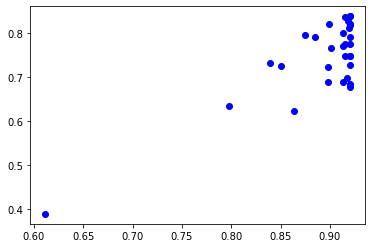

In [8]:
plt.plot(probas, changes, 'bo')
plt.show()

In [9]:
#RMSE
sq_changes = []
abs_changes = []
for each in changes:
    sq_changes.append(each**2)
    abs_changes.append(abs(each))
MSE = sum(sq_changes)/len(sq_changes)
RMSE = math.sqrt(MSE)
MAE = sum(abs_changes)/len(abs_changes)

print('MSE:', MSE)
print('RMSE:', RMSE)
print('MAE:', MAE)

percent_change = []

for i in range(len(probas)):
  #  change = probas[i] - changes[i]
    rel_change = changes[i]/probas[i]
    percent_change.append(abs(rel_change))
MAPE = sum(percent_change)/len(percent_change)
print('MAPE:', MAPE)

MSE: 0.5674700934576616
RMSE: 0.7533061087351287
MAE: 0.7482133042067289
MAPE: 0.8349202107638121


# SHAP

In [10]:
X_train_frame = pd.DataFrame(data = X_train, columns = feature_names)
X_test_frame = pd.DataFrame(data = X_test, columns = feature_names)

data_sample = shap.kmeans(X_train_frame, 100)
shap_explainer = shap.KernelExplainer(model.predict_proba, data_sample)#, link = 'identity')

shap.initjs()

In [11]:
shap_values = shap_explainer.shap_values(X_test_frame)
shap_val_feat = np.transpose(shap_values[0])
feats = np.transpose(X_test_frame.values)

0
-0.0015343396283655775 19
-0.0032657156378997354 19
-0.00392080522220728 19
0.0 19
0.0 19
-0.003226301905381118 19
0.001478744028875767 20
-0.0033808921383589874 19
0.0019341791503020012 20
-0.0028990040244634974 19
-0.00330238376714731 19
0.0023252788229372046 20
-0.0027818396225014475 19
-0.0026385613098016403 19
0.0025835639460462245 20
0.002538858593096327 20
-0.002168810892054257 19
0.0025417770440989973 20
0.0 19
-0.0018541880674048106 19
0.002747362421700039 20
0.0025132301782300193 20
0.0025775509293963217 20
0.0024090027484655052 20
-0.0025722210004435614 19
0.0030649150267042236 20
0.0015804167412558356 20
-0.0029552015606506 19
0.002560715289207899 20
0.0021855082657687985 20
-0.0015604209099011057 19
0.002167575209758743 20
0.002636413989813763 20
-0.002841319036930079 19
0.0 19
0.0 19
0.0 19
0.0014894082270093811 20
-0.00293330943332612 19
-0.0027971438448455704 19
0.0 19
-0.001024426915985227 19
0.0010220574112274616 20
0.0021719793520435238 20
0.0022198182038799252 20


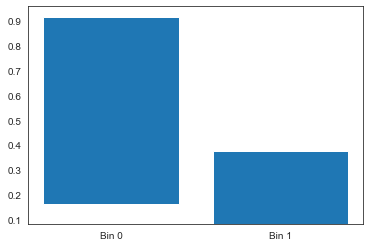

1
-0.0039127136710263855 19
-0.0021874210962584684 19
-0.003336481359500487 19
0.004497877399236322 20
0.0 19
-0.0028131907225051878 19
0.0 19
-0.0026461411718257666 19
0.0 19
-0.00395329208417966 19
-0.004006003085842869 19
0.0 19
-0.003943383858279859 19
0.020154422928225238 20
0.0 19
0.006978626778827907 20
-0.003269738079074408 19
0.0 19
-0.003243557562176258 19
-0.004754861708893776 19
0.0 19
0.0007987139598062409 20
0.0 19
0.0 19
0.019696982669691426 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.003549604112334598 19
0.006372217274945802 20
0.0048322654745590055 20
-0.002004394283012717 19
0.0 19
-0.0033697325854281646 19
0.0 19
0.003876479812312039 20
0.0 19
0.013395025690294798 20
0.0 19
-0.002406658188821742 19
0.005879909643592834 20
0.0 19
0.005282259868807732 20
-0.003538386616464828 19
0.0 19
0.008562122412533152 20
0.0 19
-0.005213970616860658 19
0.007028887250386695 20
-0.005785627592295048 19
0.0 19
-0.0024646274381802946 19
0.0 19
-0.00345625362268126 19
0.00608658079336874

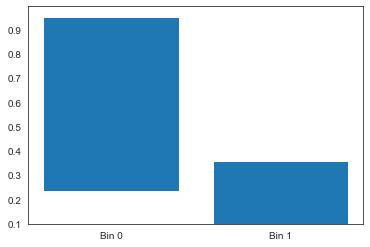

2
-0.0026225147288536643 19
-0.0027041593673822195 19
-0.0043273798110089745 19
0.0011811333844678473 20
0.00196553422240206 20
-0.0019246337138531522 19
0.0021281206878258074 20
-0.0038212211272019014 19
0.0016573381197926007 20
-0.0024396112335725306 19
-0.0014054297860871812 19
0.002304003231875351 20
0.0 19
-0.0015703632657933508 19
0.0 19
0.0 19
-0.003240909400519021 19
0.0018938844385587295 20
-0.003167605090088621 19
-0.0016588204605266221 19
0.002832127303462967 20
0.002861437397507327 20
0.002310062751784414 20
0.0 19
-0.001972565742225336 19
0.002585967508452164 20
0.0 19
-0.0016972381957146565 19
0.002380283882774864 20
0.003440081440849563 20
-0.00289698142886452 19
0.001733216760991696 20
0.004889457287763244 20
0.0 19
0.0 19
0.0 19
0.0023856906098637066 20
0.0024593684238505553 20
-0.003993966977380886 19
-0.002393296672082712 19
0.0030198236736181036 20
-0.00242921332668522 19
0.0035589143029786385 20
0.005583429966011383 20
0.002274337239063562 20
-0.0036601742291988704

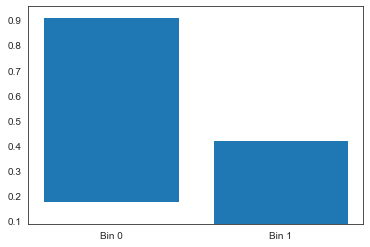

3
-0.0012898487885144028 19
-0.0035653870510771735 19
-0.0026454583917749075 19
0.0014388415059330972 20
0.0 19
-0.0018155777410827911 19
0.0014580277461688773 20
-0.002530946700514042 19
0.0037604441780456077 20
-0.003482279058323823 19
-0.0015443361551598644 19
0.002492813332484245 20
-0.004195380079767691 19
0.0 19
0.0021808688959295275 20
0.0013872155785242812 20
-0.0028156007145203887 19
0.002763010455769932 20
-0.005250635947695315 19
-0.0032921538626330127 19
0.0 19
0.0009624285979517311 20
0.0015699580705211824 20
0.002689654951347653 20
-0.0025518658237099964 19
0.0034428800883039845 20
0.0028680747036660126 20
-0.003251957576424769 19
0.0020836361369292733 20
0.0016611094843187457 20
-0.0017437565046321546 19
0.003924970960277885 20
0.003148547026206927 20
-0.003557224357382205 19
0.004913227055922731 20
0.0 19
0.0027125402145080323 20
0.001567839386561215 20
-0.0035329668688863225 19
0.0 19
0.0016903756357494852 20
-0.004359914692375538 19
0.0 19
0.0035887762920660815 20
0.0

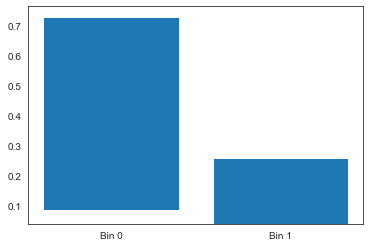

4
-0.0017139569735183657 19
-0.0021651564410443414 19
-0.0012742281997260574 19
0.007204129766323897 20
0.0 19
-0.0019675978325867927 19
0.001016192782034131 20
-0.0033578617032596347 19
0.004456302130616402 20
-0.001558504248326209 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0035178716862617754 20
0.0 19
0.0 19
0.0017913960194244072 20
0.0 19
-0.0014181539222153372 19
0.0 19
0.0 19
0.0 19
0.0 19
0.009912857545115877 20
0.0 19
0.0 19
-0.0010220782058775746 19
0.0 19
0.0 19
0.0 19
0.000902631388885633 20
0.0 19
-0.001860915276882591 19
0.0 19
0.0 19
-0.002509954467504266 19
0.0006366390823349943 20
0.0 19
-0.0012433605953787036 19
-0.0024781505936676777 19
-0.0015597078186562197 19
0.003768447638200778 20
0.003689363466949813 20
0.007407913018753043 20
-0.002844665678765901 19
0.002009604420675465 20
0.0 19
0.0011515438762134123 20
0.0 19
0.0008672972288798209 20
0.004941645371491651 20
0.0 19
-0.0021448128955926238 19
0.0 19
-0.0014518519029261268 19
0.0 19
0.007310256080166777 20
0.0008275996872

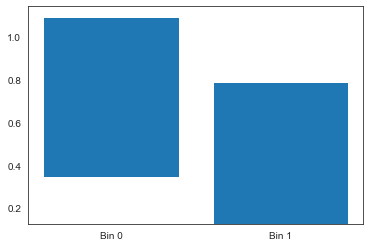

5
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0014429390852273016 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0019488957226778958 20
0.0 19
0.0 19
0.0019206231332028478 20
0.0 19
0.0 19
0.0 19
0.0009474323109558425 20
0.0 19
-0.0011887699978791744 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0007940680940674572 20
0.0 19
0.0 19
0.0 19
0.0 19


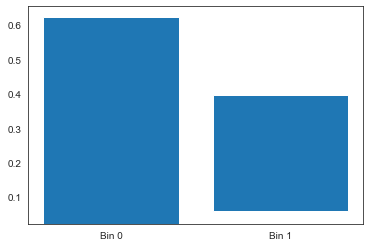

6
-0.019541935641433278 19
-0.015027766706432022 19
-0.012608095016604898 19
0.013508562553858905 20
0.013249047402852432 20
-0.01553320125914931 19
0.01261150150793594 20
-0.013401991924371803 19
0.013069853286435784 20
-0.013431610901997182 19
-0.013236209847079156 19
0.012829144728359082 20
0.011822620894801239 20
-0.01557289999790383 19
0.01539661598566669 20
0.013154018550873475 20
-0.013931320309517381 19
0.014383584288403362 20
-0.013936265915602514 19
-0.01976370823370152 19
0.01499615916965455 20
0.014445083786898877 20
0.01556320314732626 20
0.014427355051738783 20
0.011455950446288676 20
0.012498206520660804 20
0.01465108162814327 20
0.0 19
0.012299799058900218 20
0.012740229212880039 20
-0.013183805496119722 19
0.012669074058950569 20
0.012969462216184502 20
-0.012174156540697367 19
0.01074169230855146 20
0.0 19
-0.012164531056022658 19
0.01438014996864545 20
-0.01373351194237965 19
-0.022746606871861787 19
-0.011336719987930916 19
-0.01395326574893474 19
0.0126192730717979

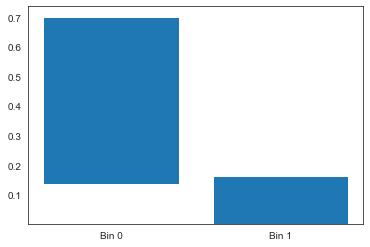

7
-0.08029898233406554 18
-0.045833429217695676 19
-0.05308567339695047 18
0.040601286268982545 20
0.03973799262606803 20
-0.04675376894825975 19
0.04175806303899199 20
-0.04349697608865949 19
0.045564576185573635 20
-0.04540243302486152 19
-0.04846696866733377 19
0.042026949818734755 20
-0.022935078576512696 19
-0.06880563508997242 18
0.04494941845866188 20
0.05106106445186956 21
-0.04393543774970074 19
0.045522861489436545 20
-0.056408914719668746 18
-0.08445030972473644 18
0.043127014139775655 20
0.04194108175173686 20
0.0437602187830573 20
0.041618736105967336 20
0.01736356154621785 20
0.04097641920375819 20
0.04299169676831957 20
-0.044760673148523056 19
0.04434744749207892 20
0.03920815938985567 20
-0.045357618640718994 19
0.0430320524132555 20
0.043426666549639725 20
-0.04800199097111668 19
0.05316101466098333 21
0.02998373782696273 20
-0.0634863280711945 18
0.042680232886517594 20
-0.04738063952070021 19
-0.08568665065557271 18
-0.05865447135706058 18
-0.048214827118725795 19
0

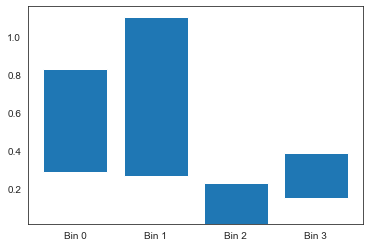

8
0.0 19
0.0 19
-0.0014412523785400366 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.0010744240234287217 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.00109979881830638 19
0.0 19
0.0 19
0.0 19
0.008966233857991307 20
0.0 19
0.0 19
0.0 19
0.022151869309567716 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.00965208008717 20
-0.002229525088171147 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0010472247632795084 20
0.0018440306965689934 20
0.0 19
0.0 19
0.0 19
0.0 19
-0.0008389658256207355 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0011910539257075636 20
0.0008832267183878917 20
0.0 19
0.0 19
0.0 19


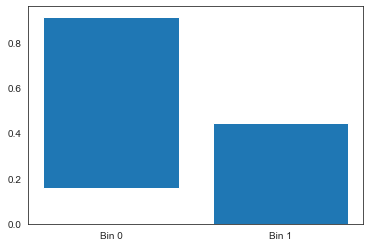

9
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.0012070569544464227 19
0.0 19
-0.001087975602859892 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.0012252236367350233 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0006687874896516288 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.012091880131847935 20
0.0 19
0.0 19
0.0 19
0.006975659870743955 20
0.0 19
0.0 19
0.0012676845227842237 20
0.0008522114991170171 20
0.0 19
0.0 19
0.0011459622672875813 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0023880427488257028 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.0015684645466996217 19


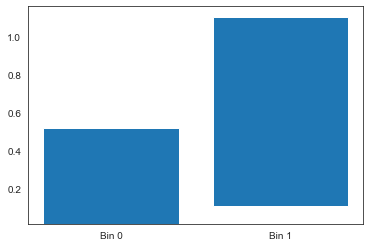

10
0.0 19
0.0 19
0.0 19
0.016221598841898555 20
-0.014698993786829095 19
-0.006712979639583783 19
0.003801899775853934 20
-0.004567542356401777 19
0.003263480316182399 20
0.0 19
0.0 19
0.009892461002188019 20
-0.007963180035430423 19
0.0 19
0.0056049395061064655 20
0.0026633932788420467 20
-0.005898184842530602 19
0.004414570206806967 20
0.0 19
0.0 19
0.0023648866664114088 20
0.0028137535124814206 20
0.0040877567595692665 20
0.002429288290381415 20
0.0 19
0.002959134988828077 20
0.002836950777850511 20
0.0 19
0.003420430801857527 20
0.002859024141057459 20
-0.007104350736394344 19
0.004527787508431691 20
0.0029770812427365734 20
0.0 19
0.004399218953998085 20
0.0 19
0.0 19
0.0041957100255652635 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0157624348539967 20
0.003454167501063421 20
0.00414437954233654 20
-0.006124439137922433 19
0.002687337542328694 20
0.015707805389292034 20
0.003337935208279852 20
0.0 19
0.0031245580212302393 20
0.003272197065712912 20
-0.0018700840429855259 19
-0.00530699256583

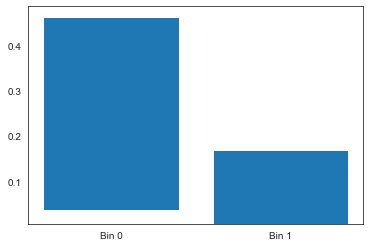

11
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.0009083167278703397 19
0.0 19
0.0 19
0.0 19
0.0013314228494217262 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0012344836411952997 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0014874934386467364 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0007709173217210208 20
0.0 19
0.0008959573885586603 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.003160709913902708 19
0.0 19
0.0 19
0.01793841281280477 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19


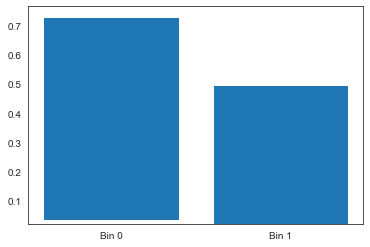

12
0.0 19
0.0 19
0.0 19
0.004296623077053252 20
0.0 19
-0.0025380189650797136 19
0.0 19
0.0 19
0.0019626315324343113 20
0.0 19
-0.0013612355087381234 19
0.0 19
-0.00438196810458702 19
-0.005658730940573314 19
0.0 19
0.0013655904170712663 20
-0.002122850486965533 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0018150870451443812 20
0.0017915489093686954 20
0.001974881981784249 20
0.0 19
0.003067255614379094 20
0.0014746550694625382 20
0.0 19
0.0010800048128033202 20
0.0 19
-0.001584643563579874 19
0.0008793337399775614 20
0.0 19
0.0 19
0.004181576180235236 20
0.0 19
0.0 19
0.0005894334292442793 20
0.0 19
0.0 19
0.0 19
0.0 19
0.005379083478679131 20
0.0 19
0.0 19
-0.0016112157967005658 19
0.0008416029876292253 20
0.0044537404924723245 20
0.0027110254153869806 20
0.0 19
0.0017751168030568643 20
0.0 19
0.0 19
-0.0025591049646428443 19
-0.007039835652408767 19
0.0 19
0.0026647180625933575 20
0.0 19
0.0013670073372323843 20
0.004941283165400628 20
0.0 19
0.0 19
-0.002050782027226139 19


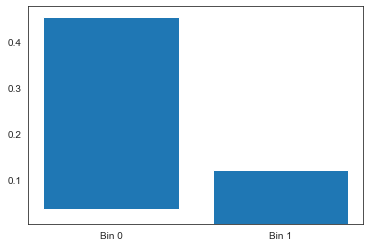

13
-0.006258709889110592 19
-0.045221550671612126 19
-0.012087708196245439 19
0.03739821633934298 20
0.0 19
-0.04887125938848208 19
0.023857807361616856 20
-0.04272589895305873 19
0.010479408170781912 20
-0.047912995304130956 19
-0.048674937942790875 19
0.031041789330795877 20
-0.056529861635145146 18
-0.08363233473272225 18
0.02716186400323156 20
0.02461658838154482 20
-0.04594715885591247 19
0.02543569989580613 20
-0.0050645261556871435 19
-0.003462994863769442 19
0.024712920999441362 20
0.026216882779807743 20
0.02729640124060595 20
0.03298676273183759 20
-0.06418505079616897 18
0.02690701211129759 20
0.037152684511868816 20
-0.004118990650310933 19
0.03588668434278236 20
0.03417378606712479 20
-0.047390759261568355 19
0.02707068405084978 20
0.022058920076853117 20
-0.04896954483563887 19
0.03282666286857411 20
-0.015326432283731761 19
0.006853088828067767 20
0.026526257540147508 20
-0.04795543179041345 19
-0.009147289430121122 19
0.024547036723673626 20
-0.04690252939253434 19
0.03

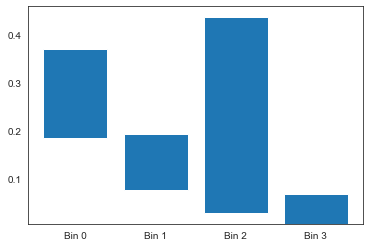

14
0.0 19
-0.0016946732741905945 19
0.0 19
0.0006492509974904692 20
0.0 19
0.0 19
0.0014738674860522438 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.002334413445992445 20
0.0 19
-0.037214014406592444 19
0.0 19
0.0014717773473803264 20
0.0009859066586552223 20
-0.01132012154523171 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0015013390130124427 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.023754829517841525 19
0.0 19
0.0015848692080227822 20
0.0 19
0.0 19
0.0 19


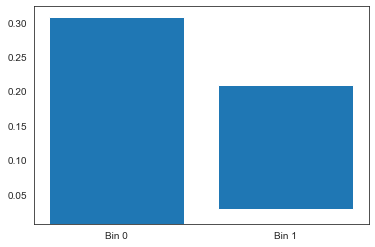

15
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0009836980436376264 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0008368477930226215 20
0.0 19
0.0 19
0.0 19
0.0 19
0.001439240197267766 20
0.0 19
-0.0009944482989457937 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0007214582555526983 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.00220225837259036 19
0.0 19
0.0 19
0.0 19
0.00052865247567907 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19


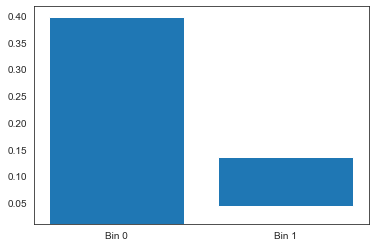

16
0.0 19
0.0 19
0.0 19
0.003585615594447894 20
0.0 19
-0.0014713735334916933 19
0.0 19
-0.0017235172962302703 19
0.0 19
0.0 19
-0.0013492826017472703 19
0.0009474173058803548 20
0.0 19
0.0 19
0.004377229217283091 20
0.0 19
-0.001194241603339724 19
0.0 19
-0.0018352432048925893 19
-0.0021354726672208613 19
0.003728202671658243 20
0.0 19
0.005083581594204273 20
0.0 19
0.004095510387218868 20
0.0 19
0.0015062325892030992 20
0.0 19
0.0 19
0.0 19
-0.0014042926136522138 19
0.0 19
0.0026644917639244148 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.0007989452150055087 19
0.0 19
-0.0013516493687756315 19
0.0 19
0.0 19
0.0034646480342571118 20
0.0 19
0.0 19
0.0 19
0.0 19


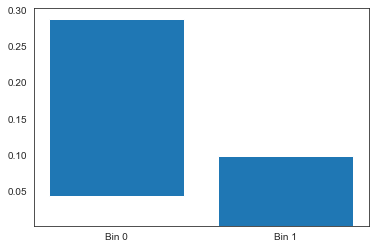

17
0.0 19
0.0 19
0.0 19
0.0005824781869213924 20
0.0 19
0.0 19
0.0 19
0.0 19
0.002751762302269617 20
0.0 19
-0.0014641232823115469 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.0025399843991149307 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.0010158688105648128 19
0.0 19
0.0 19
-0.0022028369145278837 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.0013200713853279977 19
0.0 19
0.0 19
0.000595765676853377 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0007928985379597187 20
0.0 19
0.0 19
0.0020571503825554394 20
0.0 19
0.0 19
0.0 19


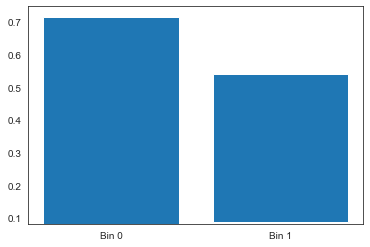

18
-0.002029216024237279 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0007721802650779153 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0010973838280793624 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0014063772401474994 20
0.0 19
0.0 19
0.0 19
0.0014720841496480563 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.001074817166494657 20
0.0 19
0.0 19
0.0 19
0.0006991527626971084 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.0027135567570223396 19


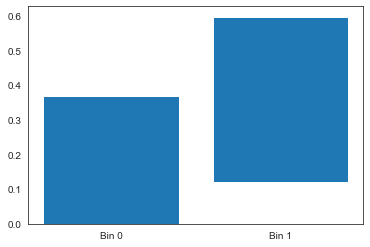

19
0.0 19
0.0 19
0.0 19
0.0012010266066533604 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.00119749974025668 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.0016780823632466246 19
0.0 19
0.0 19
0.0 19
0.001188857816214861 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0031738687224742786 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0009767685984070074 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0009723901603821972 20
0.0 19
0.0 19
-0.0014913964440444183 19
0.0 19
-0.001104742667038472 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19


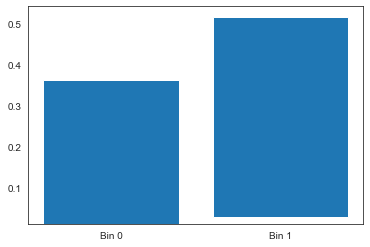

20
-0.03499554947571998 19
-0.08442150626422512 18
-0.08920198483993891 18
0.06076876328829242 21
0.07790393685721224 21
-0.08375223868966986 18
0.08345256848009625 21
-0.0810468125982276 18
0.07743143161080696 21
-0.08643141845556213 18
-0.08504153249675361 18
0.07145747562896543 21
-0.08467314907105203 18
-0.008381911548207624 19
0.08035295481453461 21
0.10111026695447412 22
-0.08320406803493241 18
0.07734427419448942 21
-0.09554796532326212 18
-0.03353174931187963 19
0.0732402407151847 21
0.0825143734239214 21
0.07886839116700367 21
0.0731241379614416 21
-0.06962812754495185 18
0.08044304773507271 21
0.07701508883915992 21
-0.09927090388599624 18
0.08127075899091729 21
0.07975465851240063 21
-0.08268267513870767 18
0.08076830091920728 21
0.0776517186579159 21
-0.08498746779817581 18
0.10886593473968234 22
-0.1305099147638316 17
0.07961629009802833 21
0.07641748270494522 21
-0.0849031518390897 18
-0.0067290841882643865 19
0.07446193743224681 21
-0.0832369450154977 18
0.06603566606309

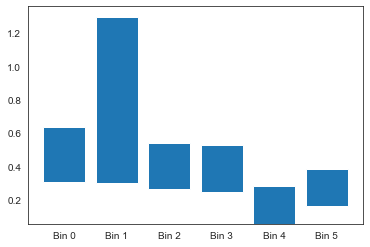

21
-0.02066033995489422 19
-0.008284777945521515 19
-0.02281177678731297 19
0.008868702019080965 20
-0.03739084536471944 19
-0.0022582279681917228 19
0.007253918115191882 20
-0.02125540050923075 19
0.0095447839593093 20
-0.0038728288163754065 19
-0.0012884681175680535 19
-0.039513078591867645 19
-0.0029386310374517333 19
0.04450232130120542 20
0.005234192045877495 20
0.02170566238655594 20
-0.010656020070341388 19
0.007158500613506369 20
-0.0015170368517422872 19
0.0 19
-0.046825556733903095 19
0.006179083894915949 20
0.006024957113004825 20
0.00804632018159801 20
0.027952073687071123 20
0.006931374722605688 20
0.007278392967432934 20
-0.0020230823012150623 19
0.0077709600804256596 20
0.0 19
-0.00933113951415429 19
0.02139635942730611 20
0.021173279518232585 20
-0.0038718925265317505 19
0.006524707641738486 20
-0.010867151503579614 19
0.0037263131426611825 20
0.008091250945898715 20
-0.003460170287182457 19
0.053839580693193244 21
-0.0058934347859994525 19
-0.002536962847465407 19
0.00

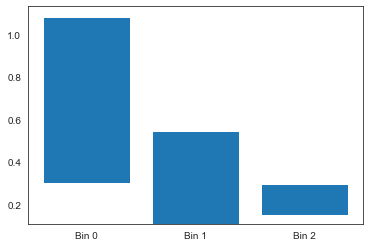

22
-0.12027743867187496 17
-0.10717373711911998 17
-0.10377774968553022 17
0.09690356747991233 21
0.10625342719372885 22
-0.10575490826830039 17
0.10837132607164648 22
-0.1023675489744855 17
0.10279944534382654 22
-0.11177836773490041 17
-0.10754361272155666 17
0.11214385070254776 22
-0.10191245582742753 17
-0.08347799750279267 18
0.1008338607138135 22
0.11213819189415564 22
-0.10548664779742786 17
0.11301989484475422 22
-0.12025424639817775 17
-0.12191637646683792 17
0.0990291642146531 21
0.111936647480329 22
0.10520849251846154 22
0.1103506507819349 22
-0.05577161247413326 18
0.1120256015654158 22
0.10978911604750874 22
-0.11376615585168554 17
0.1101218581033302 22
0.10965654650204709 22
-0.10396038567815846 17
0.09380759239366948 21
0.09467363992110084 21
-0.10853700763996202 17
0.12290328003080764 22
-0.11175048413782551 17
0.10299040142763342 22
0.08020466918555738 21
-0.1114869252319935 17
-0.09364052035019453 18
0.10427635553408374 22
-0.10982328568437491 17
0.10709740546347216 

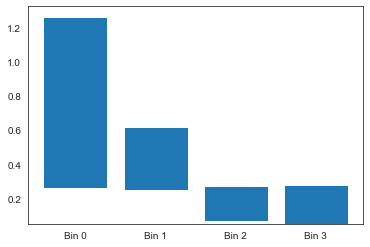

23
-0.001839847790615745 19
-0.04567307533863285 19
-0.04378178118416726 19
0.041836200692807884 20
0.039578982326158835 20
-0.04392887488374253 19
0.04405624974116201 20
-0.044338740842060215 19
0.04036543631147815 20
-0.046551380080632226 19
-0.044396324490376976 19
0.04086755221722782 20
-0.05471779935804133 18
0.0065318969750013944 20
0.04036739915693682 20
0.04201948652198645 20
-0.04407222985794024 19
0.040920029246341916 20
-0.05175718129768864 18
0.0 19
0.03234565685340968 20
0.04330076594665708 20
0.04014907020072167 20
0.03917118084190996 20
-0.04437917886637575 19
0.042291705933575896 20
0.04298438580194219 20
-0.058947882663659024 18
0.04546591838395192 20
0.04070700344231584 20
-0.044917989715200335 19
0.041481809920385554 20
0.03933697145138454 20
-0.047700983232573796 19
0.049151217330850844 20
-0.06362616101769314 18
0.04302167634274856 20
0.04386737143059588 20
-0.048301470263460294 19
0.011016355904827926 20
0.04273804814436688 20
-0.04685580481211049 19
0.04239618366

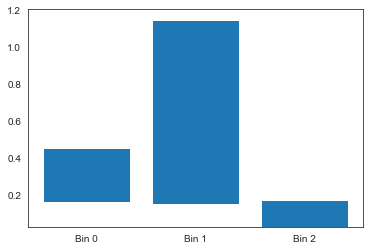

24
0.0 19
0.0 19
0.0 19
0.008977388420677468 20
0.004494435702292993 20
0.0 19
0.004970877032414278 20
0.0 19
0.010580589368620191 20
0.0 19
0.0 19
0.00383358971406475 20
0.0 19
0.0 19
0.008422182289156366 20
0.002308874747168954 20
0.0 19
0.0029716775439799226 20
-0.005097977293949285 19
0.0 19
0.004297097415784545 20
0.004142369197112139 20
0.0031676549174483315 20
0.004203370124446354 20
0.00793432892495358 20
0.0021258785357688437 20
0.004250612200503323 20
0.0 19
0.003136896391467192 20
0.0031243804965138677 20
0.0 19
0.0033248768229678094 20
0.0037776754011902836 20
0.0 19
0.00559050615647233 20
0.0 19
-0.1033456802295472 17
0.004080748032518011 20
0.0 19
0.0 19
-0.10499685319113644 17
-0.0028261612255743307 19
0.0034088688571602133 20
0.008851896069727389 20
0.0036515785999279016 20
0.0 19
0.001239903942214765 20
0.0035671997366747143 20
0.003234682000931355 20
0.0 19
0.003904448923556292 20
0.0012621980405670141 20
0.0 19
-0.001276384920789797 19
0.009197547340509468 20
0.0 19


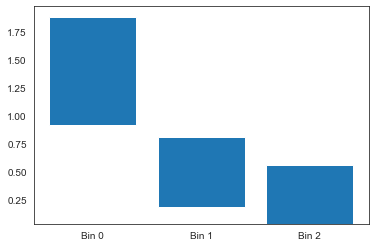

25
-0.001301438071543426 19
-0.0015088901867341131 19
-0.003126923067840265 19
0.003869667475649319 20
0.0 19
-0.0007746168717183144 19
0.0031973620638044986 20
-0.002284407244300124 19
0.0 19
-0.0019425675389785346 19
-0.0026767744663237225 19
0.0 19
0.0 19
0.0 19
0.003516591525835888 20
0.002884564175095611 20
-0.000566111083605908 19
0.0025869814457335216 20
0.0 19
-0.0010534885213199507 19
0.002348632856967958 20
0.0 19
0.0028178596713463455 20
0.003112828718703331 20
0.0020016226733148013 20
0.0008388705169515842 20
0.0017819362949335615 20
0.0 19
0.0028317632294301287 20
0.0021214879071810577 20
-0.0019371916844348191 19
0.0015789191573314931 20
0.0018059773119685207 20
-0.0021819467300701056 19
0.0 19
0.0 19
-0.00710770211909773 19
0.0034222575531433763 20
0.0 19
0.0 19
-0.003608459374750633 19
0.0 19
0.002768254137142212 20
0.0 19
0.0010267359642922025 20
-0.002971084852657069 19
0.0 19
0.0019901543046265124 20
0.0 19
0.0 19
0.0016347121290136712 20
0.007000234790215568 20
0.0 

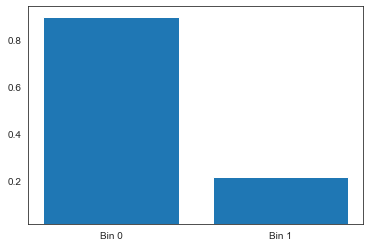

26
-0.021751604904526572 19
-0.027905311142580047 19
-0.027207217799038674 19
0.027813017706888266 20
0.03831165153517349 20
-0.026216093005555108 19
0.03758525125336387 20
-0.026125236840181004 19
0.0352811297591801 20
-0.02715880190872688 19
-0.025976957780920268 19
0.03292746152879111 20
0.025354908618428512 20
-0.0222519034049026 19
0.03880632770588999 20
0.0 19
-0.026566571313023785 19
0.03695906863302667 20
-0.02620833319386892 19
-0.02068466019853743 19
0.03846804053000502 20
0.0382705815705644 20
0.03811751279765435 20
0.03541462063881662 20
0.06711958710207086 21
0.03643491611285249 20
0.03339404573526272 20
-0.02452874900938487 19
0.03408135375612906 20
0.03237454943466031 20
-0.02836630212379801 19
0.03667690171783586 20
0.036555921558381305 20
-0.025649431237745962 19
0.0 19
-0.024527488928846458 19
-0.006901907852136581 19
0.03939893967855798 20
-0.027596344311000998 19
0.04935697276322736 20
-0.006812100654267202 19
-0.02691596066577248 19
0.030514034132056445 20
0.022018

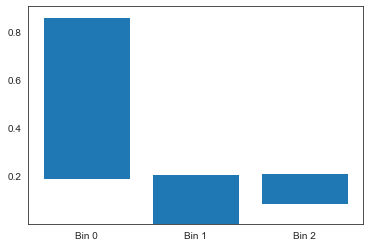

27
-0.049310004548830055 19
-0.030731660976659414 19
-0.03723571932298589 19
0.029162326970009533 20
0.02580121097405197 20
-0.029844298145985715 19
0.03245430707774635 20
-0.02720510636583795 19
0.03130336964993086 20
-0.02854912402203441 19
-0.03335771395564269 19
0.033067933669223004 20
0.014421531204449112 20
0.021954533662646852 20
0.030914385842691516 20
0.0088117024062844 20
-0.026514993763632644 19
0.036992424242822564 20
-0.034964601097174336 19
-0.04895543571608496 19
0.03859725794069788 20
0.0331731930070856 20
0.03349921167038539 20
0.03355897207387773 20
0.02971120586572925 20
0.03371569028260671 20
0.03212773789509038 20
-0.02367279868003791 19
0.026453059660680456 20
0.03206772286120607 20
-0.02838198420533533 19
0.032613701012826984 20
0.03146389200984759 20
-0.030651727614842306 19
0.008008671602189599 20
-0.012660887120820141 19
-0.04433028040645351 19
0.03497385655725263 20
-0.027284864461022518 19
-0.044138530088661254 19
-0.042216486194511335 19
-0.0308828294522545

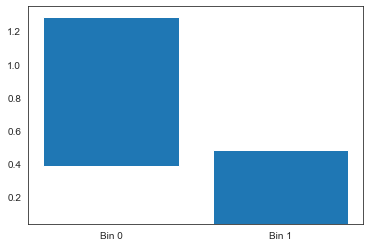

28
0.0 19
0.0 19
-0.005493983777692724 19
0.0024023727020327512 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.002219768048307036 20
0.0 19
0.0 19
0.0038169220571581675 20
0.0022761273590393705 20
0.0 19
0.0013375532481219032 20
-0.0014320460221441955 19
0.0 19
0.0012581979504425744 20
0.0 19
0.003188726475275905 20
0.0015408737128859984 20
-0.0272642440893499 19
0.0019358350189896123 20
0.001925233535595594 20
0.0 19
0.0 19
0.0 19
0.0 19
0.001998381694100826 20
0.0016764775565613066 20
-0.002171379440975285 19
0.0 19
0.0 19
-0.011352240284011644 19
-0.06182295601696319 18
0.0 19
0.0 19
-0.007624176721618558 19
-0.002115654145968593 19
0.0019260526611183382 20
0.0 19
0.0020620249073923236 20
-0.001126361494844852 19
0.002245961421405207 20
0.0015293315835928634 20
0.0022341395695856248 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.08865499724737096 18
-0.006037500916177468 19
0.0022331551815096273 20
0.0 19
0.0022120118864580596 20
0.002681539543514605 20
0.0 19
0.0 19
0.0 19


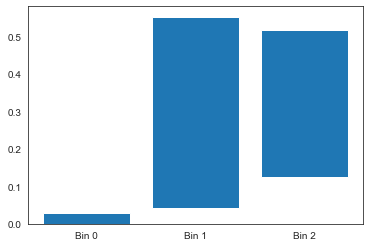

29
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0012241486635048426 20
0.0 19
0.002302160661286301 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0011814284537065012 20
0.0 19
0.0 19
0.002082771209787282 20
-0.0015513954820444709 19
0.0007563294166572643 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
0.0011108014191253401 20
0.000536224793597162 20
0.0 19
0.0 19
0.0 19
-0.01297526852157337 19
0.0 19
0.0 19
0.0 19
-0.0131764809742417 19
0.0 19
0.0 19
0.00215834965939532 20
0.0 19
0.0 19
0.0 19
0.0 19
0.0 19
-0.002958045232508588 19
0.0 19
0.0006587812758427625 20
0.0 19
0.0 19
0.0 19
-0.0011487049088377832 19
0.000881420281736156 20
0.0 19
0.0018485188760728466 20
0.0017894788940341355 20
0.0 19
0.0021647134757170616 20
0.0 19


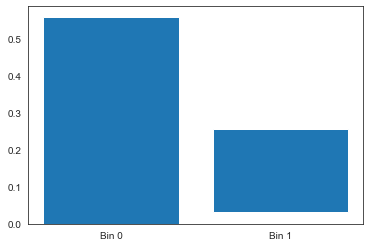

In [12]:
shap_distribs = []
sns.set_style("white")
for i in range(len(feat_list)):
    print (i)
    shap_vals = shap_val_feat[i]
    
    #zscore = scp.stats.zscore(shap_vals)
    
    #print(len(shap_vals))
    #print(each)
    #rel_shap_vals = []
    #for n in range(len(zscore)):
    #    if type(zscore[n]) != float or (zscore[n] < 3 and zscore[n] > -3):
    #        rel_shap_vals.append(shap_vals[n])
    #print(len(rel_shap_vals))

    #shap_min = math.floor(min(rel_shap_vals)*100)/100.0
    #shap_max = math.ceil(max(rel_shap_vals)*100)/100.0
    #print(min(shap_vals), max(shap_vals))
    #print(shap_min, shap_max)
    #bins = np.linspace(shap_min, shap_max+0.01, 20)
    
    bins = np.arange(-1, 1, 0.05)
    
    feat_vals = []
    for sbin in range(len(bins)):
        nl = []
        feat_vals.append(nl)
    
    for j in range(len(shap_vals)):
        val = shap_vals[j]
        b = 0
        cur_bin = bins[b]
        idx = b

        while val > cur_bin:
            #print(cur_bin)
            idx = b
            b+=1
            cur_bin = bins[b]

        print(val, idx)
        feat_vals[idx].append(feats[i][j])
        
    for each in feat_vals:
        zscore = scp.stats.zscore(each)
        #print(each)
        for n in range(len(zscore)):
            if zscore[n] > 3 or zscore[n] < -3:
                np.delete(zscore, n)
                del each[n]
        #print(each)
    #append min and max to dictionary
    mins = []
    maxes = []
    width = []
    #print(feat_vals)
    n = 0
    for each in feat_vals:
        if each != []:
            mins.append(min(each))
            maxes.append(max(each))
            width.append("Bin "+str(n))
            n+=1
    plt.bar(width, maxes, bottom = mins)
    plt.show()
    
    feat_name = feat_list[i]
    
    feat_dict = {'Feature Name': feat_name}
    for each in feat_vals:
        if each != []:
            mins.append(min(each))
            maxes.append(max(each))
        else:
            mins.append(None)
            maxes.append(None)
            
    feat_dict['bins'] = bins
    feat_dict['mins'] = mins
    feat_dict['maxes'] = maxes
    #i = 1
    #for n in range(len(feat_vals)-1):
     #   bin_name = "Bin" + str(i)
      #  i+=1
        
       # shap_range = (bins[n], bins[n+1])
        #if feat_vals[n] != []:
         #   feat_range = (min(feat_vals[n]), max(feat_vals[n]))
        #else:
         #   feat_range = None
        
        #feat_dict[bin_name+"_shap_vals"] = shap_range
        #feat_dict[bin_name+"_feat_vals"] = feat_range
    shap_distribs.append(feat_dict)

In [13]:
def create_samples(shap_explainer, iterations, row, features, top = 10):
    length = len(features)
    
    exp = []
    rel_exp = []
    
    for j in range(iterations):
        #print(X_test_frame.loc[row])
        shap_values = shap_explainer.shap_values(row)
        #print(shap_values)

        importances = []
        
        if type(shap_explainer) == shap.explainers.kernel.KernelExplainer:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][0][i]
                abs_val = abs(shap_values[0][0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
        else:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][i]
                abs_val = abs(shap_values[0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
                #print(entry)

        importances.sort(key=lambda tup: tup[2], reverse = True)
        
        exp.append(importances)

        rel_feat = []

        for i in range(top):
            feat = importances[i]
            if feat[2] > 0:
                rel_feat.append(feat)
                
        rel_exp.append(rel_feat)
        
    return exp, rel_exp

In [15]:
#shap_stability_scores = []
probas = []
shap_changes = []

for instance in results:
    
    print("INDEX = %d" %instance['index'])
    patients_feat = pd.Series(instance['scaled_vector'])
    prediction = instance['predictions']
    probas.append(instance['prediction_probability'][0])
    
    loc = results.index(instance)
    
    exp, rel_exp = create_samples(shap_explainer, 3, patients_feat.values.reshape(-1, 30), feature_names, top = MAX_FEAT)
    
    features = []
    shap_vals = []

    for explanation in rel_exp:
        features.extend([feat[0] for feat in explanation])
        shap_vals.extend([feat for feat in explanation])
        
    #arr = [np.array(x) for x in shap_vals]
    #mean_vals = [np.mean(k) for k in zip(*arr)]
    #print(shap_vals, mean_vals)
    
    counter = Counter(features).most_common(MAX_FEAT)

    feats = [feat[0] for feat in counter]
    
    rel_feats = []
    
    #print(shap_vals)
    
    for feat in feats:
        vals = [i[1] for i in shap_vals if i[0] == feat]
        #print(feat, vals)
        val = np.mean(vals)
        rel_feats.append((feat, val))
    
    intervals = []
    for item in rel_feats:
        feat = item [0]
        val = item[1]
        print("Creating distribution for feature", rel_feats.index(item))
        
        #print(item)
        #print(feat)
        n = feat_list.index(feat)
        feat_dict = shap_distribs[n]
        
        if feat_dict['Feature Name'] != feat:
            for each in distribs:
                if feat_dict['Feature Name'] == feat:
                    feat_dict = each
        
        bins = feat_dict['bins']
        mins = feat_dict['mins']
        maxes = feat_dict['maxes']
        #print (feat, val, bins, mins, maxes)
        
        i = 0
        while val > bins[i]:
            idx = i
            i+=1
        #print (i)
        if mins[i] != None:
            min_val = mins[i]
            max_val = maxes[i]
        else:
            j = i
            while mins[j] == None and j > 0:
                min_val = mins[j-1]
                max_val = maxes[j-1]
                j = j-1
                
        interval = max_val - min_val
        
        index = feat_list.index(feat)
        int_min = max_val
        int_max = max_val + interval
        intervals.append((feature_name, index, int_min, int_max))

    diffs = []
    for iteration in range(3):
        print("Pertubing - Run", iteration+1)
        alt_x = np.copy(patients_feat)
        #print("original:", alt_x)
        for each in intervals:
            new_val = random.uniform(each[2], each[3])
         #   print(each[1])
         #   print(new_val)
            alt_x[each[1]] = new_val
        #print("altered:", alt_x)
        p2 = model.predict_proba(alt_x.reshape(-1, len(alt_x)))[0][0]
        diff = p1-p2
        diffs.append(diff)
    
    shap_changes.append(np.mean(diffs))


INDEX = 52



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 5



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 38



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 21



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 12



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 24



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 57



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 62



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 30



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 16



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 9



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 45



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 33



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 35



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 4



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 7



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 47



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 26



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 22



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 60



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 15



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 18



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 23



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 27



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 29



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 32



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 43



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 44



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 48



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 49



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 51



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 59



Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3


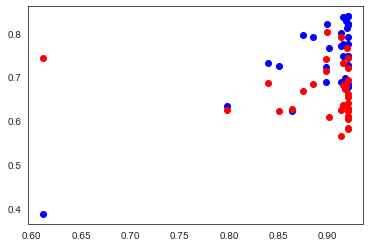

In [16]:
plt.plot(probas, changes, 'bo', label = 'LIME')
plt.plot(probas, shap_changes, 'ro', label = 'SHAP')
plt.show()

In [17]:
#RMSE
sq_changes = []
abs_changes = []
for each in shap_changes:
    sq_changes.append(each**2)
    abs_changes.append(abs(each))
MSE = sum(sq_changes)/len(sq_changes)
RMSE = math.sqrt(MSE)
MAE = sum(abs_changes)/len(abs_changes)

print('MSE:', MSE)
print('RMSE:', RMSE)
print('MAE:', MAE)

percent_change = []

for i in range(len(probas)):
    #change = probas[i] - shap_changes[i]
    rel_change = changes[i]/probas[i]
    percent_change.append(abs(rel_change))
MAPE = sum(percent_change)/len(percent_change)
print('MAPE:', MAPE)

MSE: 0.45187827966739913
RMSE: 0.672218922425871
MAE: 0.6694486830383539
MAPE: 0.8349202107638121


In [29]:
tree_explainer = shap.TreeExplainer(model)#, data_sample)
shap_values = tree_explainer.shap_values(X_test_frame)
shap_val_feat = np.transpose(shap_values)
feats = np.transpose(X_test_frame.values)

0


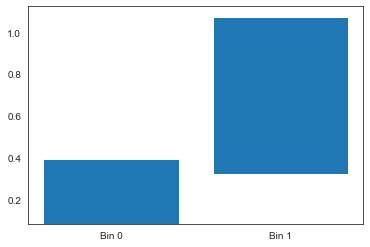

1


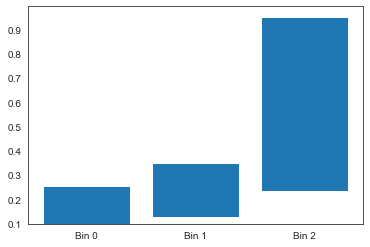

2


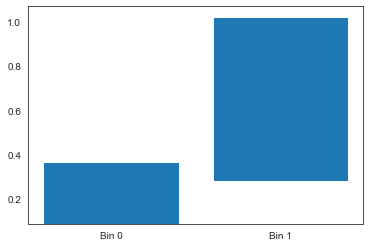

3


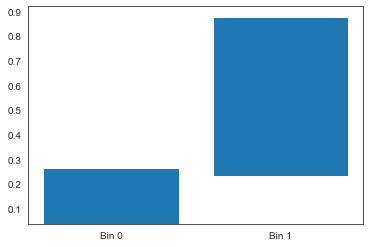

4


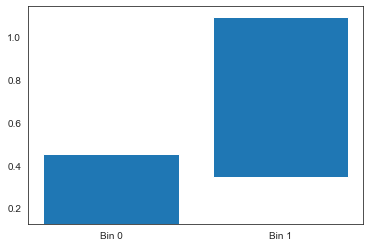

5


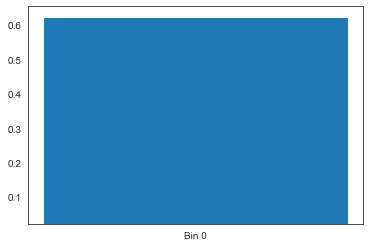

6


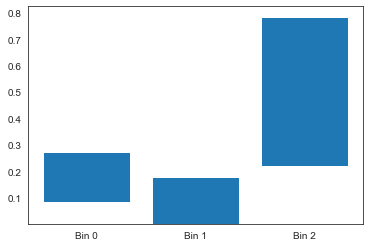

7


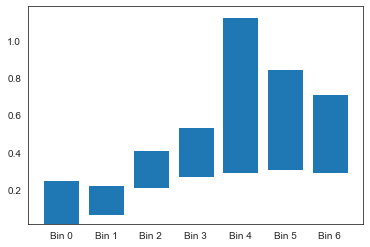

8


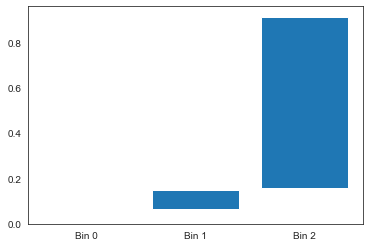

9


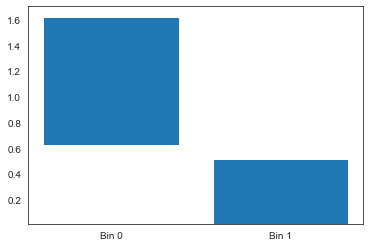

10


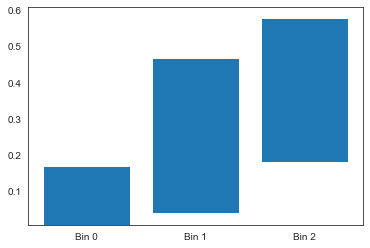

11


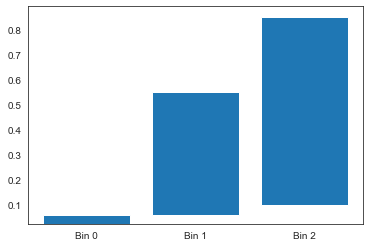

12


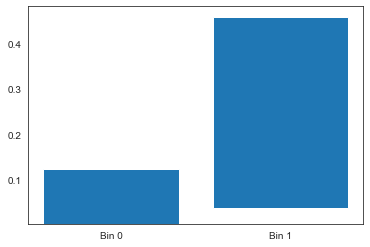

13


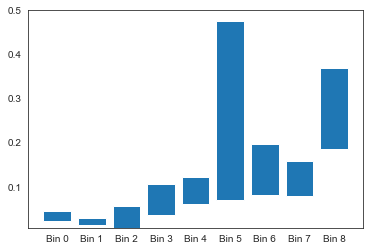

14


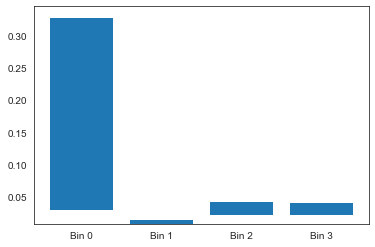

15


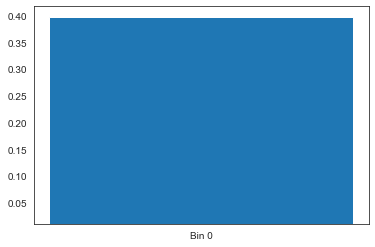

16


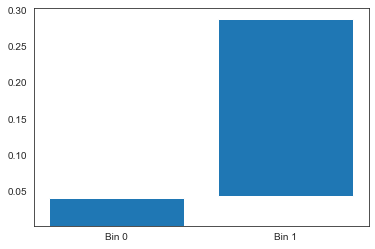

17


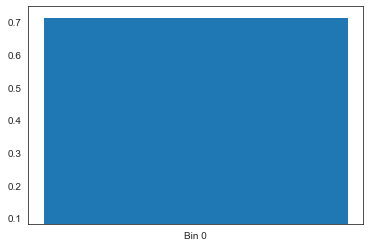

18


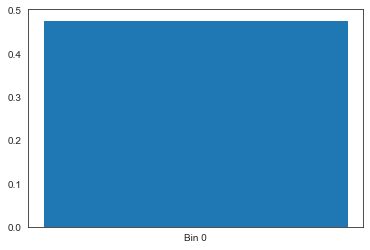

19


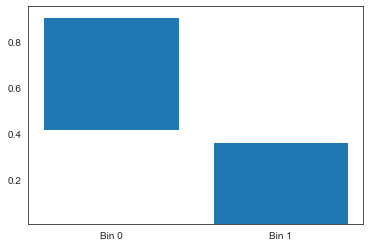

20


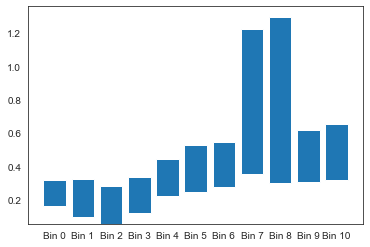

21


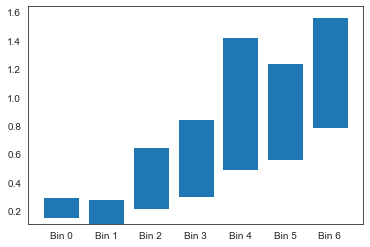

22


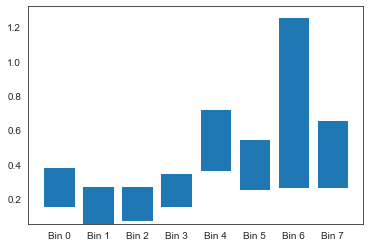

23


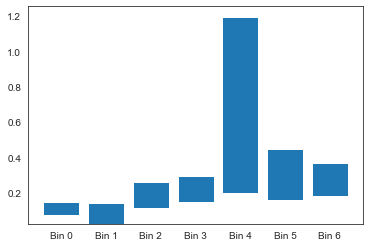

24


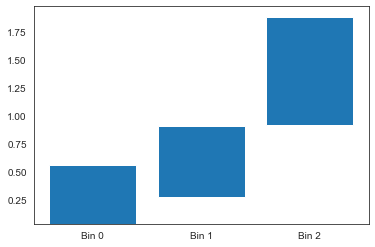

25


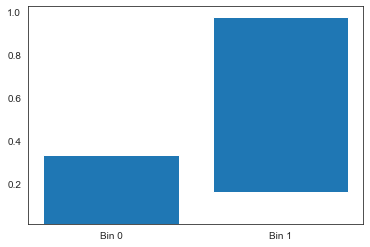

26


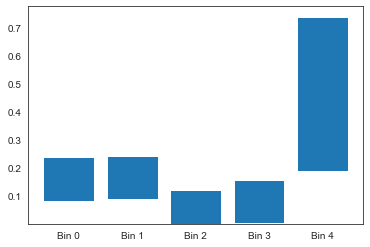

27


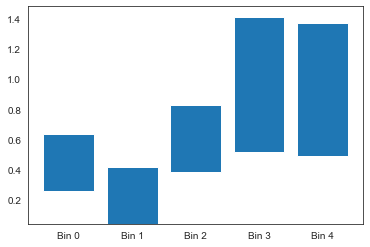

28


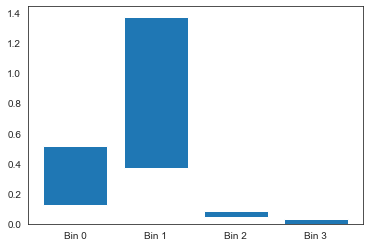

29


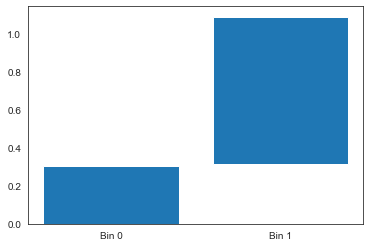

In [30]:
tree_distribs = []
sns.set_style("white")
for i in range(len(feat_list)):
    print (i)
    shap_vals = shap_val_feat[i]
    
    #zscore = scp.stats.zscore(shap_vals)
    
    #print(len(shap_vals))
    #print(each)
    #rel_shap_vals = []
    #for n in range(len(zscore)):
    #    if type(zscore[n]) != float or (zscore[n] < 3 and zscore[n] > -3):
    #        rel_shap_vals.append(shap_vals[n])
    #print(len(rel_shap_vals))

    #shap_min = math.floor(min(rel_shap_vals)*100)/100.0
    #shap_max = math.ceil(max(rel_shap_vals)*100)/100.0
    #print(min(shap_vals), max(shap_vals))
    #print(shap_min, shap_max)
    #bins = np.linspace(shap_min, shap_max+0.01, 20)
    
    bins = np.arange(-1, 1, 0.1)
    
    feat_vals = []
    for sbin in range(len(bins)):
        nl = []
        feat_vals.append(nl)
    
    for j in range(len(shap_vals)):
        val = shap_vals[j]
        b = 0
        cur_bin = bins[b]
        idx = b

        while val > cur_bin:
            #print(cur_bin)
            idx = b
            b+=1
            cur_bin = bins[b]

        #print(val, idx)
        feat_vals[idx].append(feats[i][j])
        
    for each in feat_vals:
        zscore = scp.stats.zscore(each)
        #print(each)
        for n in range(len(zscore)):
            if zscore[n] > 3 or zscore[n] < -3:
                np.delete(zscore, n)
                del each[n]
        #print(each)
    #append min and max to dictionary
    mins = []
    maxes = []
    width = []
    #print(feat_vals)
    n = 0
    for each in feat_vals:
        if each != []:
            mins.append(min(each))
            maxes.append(max(each))
            width.append("Bin "+str(n))
            n+=1
    plt.bar(width, maxes, bottom = mins)
    plt.show()
    
    feat_name = feat_list[i]
    
    feat_dict = {'Feature Name': feat_name}
    for each in feat_vals:
        if each != []:
            mins.append(min(each))
            maxes.append(max(each))
        else:
            mins.append(None)
            maxes.append(None)
            
    feat_dict['bins'] = bins
    feat_dict['mins'] = mins
    feat_dict['maxes'] = maxes
    #i = 1
    #for n in range(len(feat_vals)-1):
     #   bin_name = "Bin" + str(i)
      #  i+=1
        
       # shap_range = (bins[n], bins[n+1])
        #if feat_vals[n] != []:
         #   feat_range = (min(feat_vals[n]), max(feat_vals[n]))
        #else:
         #   feat_range = None
        
        #feat_dict[bin_name+"_shap_vals"] = shap_range
        #feat_dict[bin_name+"_feat_vals"] = feat_range
    tree_distribs.append(feat_dict)

In [31]:
tree_changes = []
probas = []
feat_list = list(feature_names)

for instance in results:
    
    print("INDEX = %d" %instance['index'])
    patients_feat = pd.Series(instance['scaled_vector'])
    prediction = instance['predictions']
    probas.append(instance['prediction_probability'][0])
    
    loc = results.index(instance)
    
    exp, rel_exp = create_samples(tree_explainer, 3, patients_feat.values.reshape(-1, 30), feature_names, top = MAX_FEAT)
    
    features = []
    shap_vals = []

    for explanation in rel_exp:
        features.extend([feat[0] for feat in explanation])
        shap_vals.extend([feat for feat in explanation])
        
    #arr = [np.array(x) for x in shap_vals]
    #mean_vals = [np.mean(k) for k in zip(*arr)]
    #print(shap_vals, mean_vals)
    
    counter = Counter(features).most_common(MAX_FEAT)

    feats = [feat[0] for feat in counter]
    
    rel_feats = []
    
    #print(shap_vals)
    
    for feat in feats:
        vals = [i[1] for i in shap_vals if i[0] == feat]
        #print(feat, vals)
        val = np.mean(vals)
        rel_feats.append((feat, val))
    
    intervals = []
    for item in rel_feats:
        feat = item [0]
        val = item[1]
        print("Creating distribution for feature", rel_feats.index(item))
        
        #print(item)
        #print(feat)
        n = feat_list.index(feat)
        feat_dict = tree_distribs[n]
        
        if feat_dict['Feature Name'] != feat:
            for each in distribs:
                if feat_dict['Feature Name'] == feat:
                    feat_dict = each
        
        bins = feat_dict['bins']
        mins = feat_dict['mins']
        maxes = feat_dict['maxes']
        #print (feat, val, bins, mins, maxes)
        
        i = 0
        while val > bins[i]:
            idx = i
            i+=1
        #print (i)
        if mins[i] != None:
            min_val = mins[i]
            max_val = maxes[i]
        else:
            j = i
            while mins[j] == None and j > 0:
                min_val = mins[j-1]
                max_val = maxes[j-1]
                j = j-1
                
        interval = max_val - min_val
        
        index = feat_list.index(feat)
        int_min = max_val
        int_max = max_val + interval
        intervals.append((feature_name, index, int_min, int_max))

    diffs = []
    for iteration in range(3):
        print("Pertubing - Run", iteration+1)
        alt_x = np.copy(patients_feat)
        #print("original:", alt_x)
        for each in intervals:
            new_val = random.uniform(each[2], each[3])
         #   print(each[1])
         #   print(new_val)
            alt_x[each[1]] = new_val
        #print("altered:", alt_x)
        p2 = model.predict_proba(alt_x.reshape(-1, len(alt_x)))[0][0]
        diff = p1-p2
        diffs.append(diff)
    
    tree_changes.append(np.mean(diffs))

INDEX = 52
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 5
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
INDEX = 38
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for featur

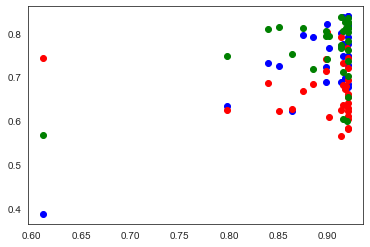

In [32]:
plt.plot(probas, changes, 'bo', label = 'LIME')
plt.plot(probas, shap_changes, 'ro', label = 'SHAP')
plt.plot(probas, tree_changes, 'go', label = 'SHAP')
plt.show()

In [33]:
#RMSE
sq_changes = []
abs_changes = []
for each in tree_changes:
    sq_changes.append(each**2)
    abs_changes.append(abs(each))
MSE = sum(sq_changes)/len(sq_changes)
RMSE = math.sqrt(MSE)
MAE = sum(abs_changes)/len(abs_changes)

print('MSE:', MSE)
print('RMSE:', RMSE)
print('MAE:', MAE)

percent_change = []

for i in range(len(probas)):
    #change = probas[i] - tree_changes[i]
    rel_change = changes[i]/probas[i]
    percent_change.append(abs(rel_change))
MAPE = sum(percent_change)/len(percent_change)
print('MAPE:', MAPE)

MSE: 0.5891517307395491
RMSE: 0.7675621999157782
MAE: 0.7643445283174515
MAPE: 0.8349202107638121


In [23]:
mean_changes = []
rank_corrs = []
IDS = np.arange(1, len(results)+1, 1)
for instance in results:
    patients_feat = pd.Series(instance['scaled_vector'])
    shap_exp, rel_exp = create_samples(shap_explainer, 1, patients_feat.values.reshape(-1, 30), feature_names, top = MAX_FEAT)
    tree_exp, rel_exp = create_samples(shap_explainer, 1, patients_feat.values.reshape(-1, 30), feature_names, top = MAX_FEAT)

    shap_weights = [0]*len(features)
    tree_weights = [0]*len(features)

    for each in features:
        list_idx = feat_list.index(each)
        #print ("Feature", list_idx)
        for explanation in shap_exp[0]:
            #print(explanation)
            if each in explanation[0]:
                shap_weights[list_idx] = explanation[1]
        for explanation in tree_exp[0]:
            if each in explanation[0]:
                tree_weights[list_idx] = explanation[1]

    weight_diff = [abs(shap_weights[i]-tree_weights[i]) for i in range(len(shap_weights))]
    mean_change = np.mean(weight_diff)
    print ('Mean change in shap values:', mean_change)

    shap_ranking = scp.stats.rankdata(shap_weights)
    tree_ranking = scp.stats.rankdata(tree_weights)
    corr, p_val = scp.stats.spearmanr(shap_weights, tree_weights)
    print('Rank Correlation:', corr)
    
    mean_changes.append(mean_change)
    rank_corrs.append(corr)


Mean change in shap values: 0.00011709442667653438
Rank Correlation: 1.0



Mean change in shap values: 0.0002307163180002921
Rank Correlation: 0.9979695431472081



Mean change in shap values: 0.00024152482288078796
Rank Correlation: 0.9993680884676146



Mean change in shap values: 0.0003336889374252477
Rank Correlation: 1.0



Mean change in shap values: 0.00029355057186906117
Rank Correlation: 0.9972927241962775



Mean change in shap values: 0.0002778211495390574
Rank Correlation: 0.9979695431472081



Mean change in shap values: 0.0005614615459929594
Rank Correlation: 1.0



Mean change in shap values: 0.0006543302405435945
Rank Correlation: 0.9580036376934334



Mean change in shap values: 0.0002932334007778231
Rank Correlation: 0.9985315712187959



Mean change in shap values: 0.00021823186695979352
Rank Correlation: 1.0



Mean change in shap values: 0.00025180695383613115
Rank Correlation: 1.0



Mean change in shap values: 0.0001986863933047108
Rank Correlation: 1.0



Mean change in shap values: 0.0003514090331218513
Rank Correlation: 0.9993680884676146



Mean change in shap values: 0.00028902553459301075
Rank Correlation: 0.9992657856093979



Mean change in shap values: 0.00018885883854106444
Rank Correlation: 0.9993680884676146



Mean change in shap values: 0.0003462581192642672
Rank Correlation: 0.9993231810490694



Mean change in shap values: 0.0003033798445677388
Rank Correlation: 1.0



Mean change in shap values: 0.00041545109156051937
Rank Correlation: 0.9993231810490694



Mean change in shap values: 0.00024461363040056044
Rank Correlation: 0.9662552918869455



Mean change in shap values: 0.0006474606333775751
Rank Correlation: 0.9601184360106375



Mean change in shap values: 0.0005001130787085029
Rank Correlation: 0.9662552918869455



Mean change in shap values: 0.0003822440271933523
Rank Correlation: 0.9993231810490694



Mean change in shap values: 0.0004187980204635224
Rank Correlation: 1.0



Mean change in shap values: 0.0004168343051996463
Rank Correlation: 1.0



Mean change in shap values: 0.00028067961530664763
Rank Correlation: 1.0



Mean change in shap values: 0.00040166106823698127
Rank Correlation: 1.0



Mean change in shap values: 0.00024281539424551025
Rank Correlation: 1.0



Mean change in shap values: 0.0004103836346495517
Rank Correlation: 0.9993231810490694



Mean change in shap values: 0.000268946019800916
Rank Correlation: 1.0



Mean change in shap values: 0.0002740205698385632
Rank Correlation: 0.9992657856093979



Mean change in shap values: 0.00037348947776980426
Rank Correlation: 0.9656013119939593



Mean change in shap values: 0.00023583695531438723
Rank Correlation: 1.0


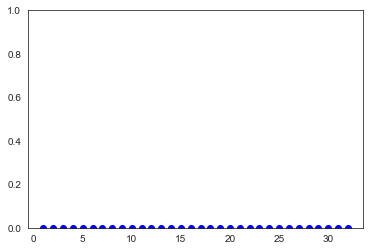

In [24]:
plt.plot(IDS, mean_changes, 'bo')
plt.ylim(0, 1)
plt.show()

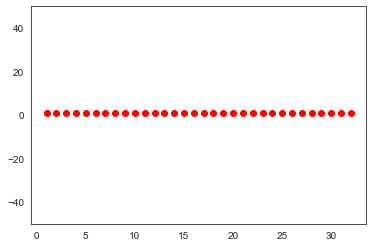

In [25]:
plt.plot(IDS, rank_corrs, 'ro')
plt.ylim(-50,50)
plt.show()

In [26]:
for i in range(len(shap_distribs)):
    print("Kernel:\n", len(shap_distribs[i]['bins']), len(shap_distribs[i]['mins']), len(shap_distribs[i]['maxes']))
    print("Tree:\n", len(tree_distribs[i]['bins']), len(tree_distribs[i]['mins']), len(tree_distribs[i]['maxes']))

Kernel:
 40 42 42
Tree:
 40 42 42
Kernel:
 40 42 42
Tree:
 40 44 44
Kernel:
 40 42 42
Tree:
 40 42 42
Kernel:
 40 42 42
Tree:
 40 42 42
Kernel:
 40 42 42
Tree:
 40 43 43
Kernel:
 40 42 42
Tree:
 40 41 41
Kernel:
 40 42 42
Tree:
 40 45 45
Kernel:
 40 44 44
Tree:
 40 51 51
Kernel:
 40 42 42
Tree:
 40 43 43
Kernel:
 40 42 42
Tree:
 40 43 43
Kernel:
 40 42 42
Tree:
 40 44 44
Kernel:
 40 42 42
Tree:
 40 43 43
Kernel:
 40 42 42
Tree:
 40 43 43
Kernel:
 40 44 44
Tree:
 40 52 52
Kernel:
 40 42 42
Tree:
 40 44 44
Kernel:
 40 42 42
Tree:
 40 41 41
Kernel:
 40 42 42
Tree:
 40 42 42
Kernel:
 40 42 42
Tree:
 40 41 41
Kernel:
 40 42 42
Tree:
 40 41 41
Kernel:
 40 42 42
Tree:
 40 42 42
Kernel:
 40 46 46
Tree:
 40 56 56
Kernel:
 40 43 43
Tree:
 40 52 52
Kernel:
 40 44 44
Tree:
 40 53 53
Kernel:
 40 43 43
Tree:
 40 50 50
Kernel:
 40 43 43
Tree:
 40 44 44
Kernel:
 40 42 42
Tree:
 40 42 42
Kernel:
 40 43 43
Tree:
 40 46 46
Kernel:
 40 42 42
Tree:
 40 49 49
Kernel:
 40 43 43
Tree:
 40 45 45
Kernel:
 40 42

In [27]:
for i in range(len(shap_distribs)):
    print("Kernel:\n", shap_distribs[i]['mins'])
    print("Tree:\n", tree_distribs[i]['mins'])

Kernel:
 [0.16314496314496313, 0.08378378378378382, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 0.16314496314496313, 0.08378378378378382, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
Tree:
 [0.08378378378378382, 0.32088452088452085, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 0.08378378378378382, 0.32088452088452085, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
Kernel:
 [0.23564013840830456, 0.09861591695501731, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 0.23564013840830456, 0.09861591695501731, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
Tree:
 [0.09861591695501731, 0.20795